## Ordinal Classification using mord Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mord
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as IMBPipeline
from sklearn2pmml import sklearn2pmml
from sklearn2pmml import ColumnTransformer
from sklearn2pmml.pipeline import PMMLPipeline
from jpmml_evaluator import make_evaluator
from jpmml_evaluator.py4j import Py4JBackend

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Data Import
df = pd.read_csv('../../../data/winequality-white.csv',sep=';')
df.shape
df.quality.unique()

array([6, 5, 7, 8, 4, 3, 9])

## Data preprocessing

In [4]:
# Duplicates dropping
df.drop_duplicates(inplace=True)
df.shape

(3961, 12)

In [5]:
# Check Null Data
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

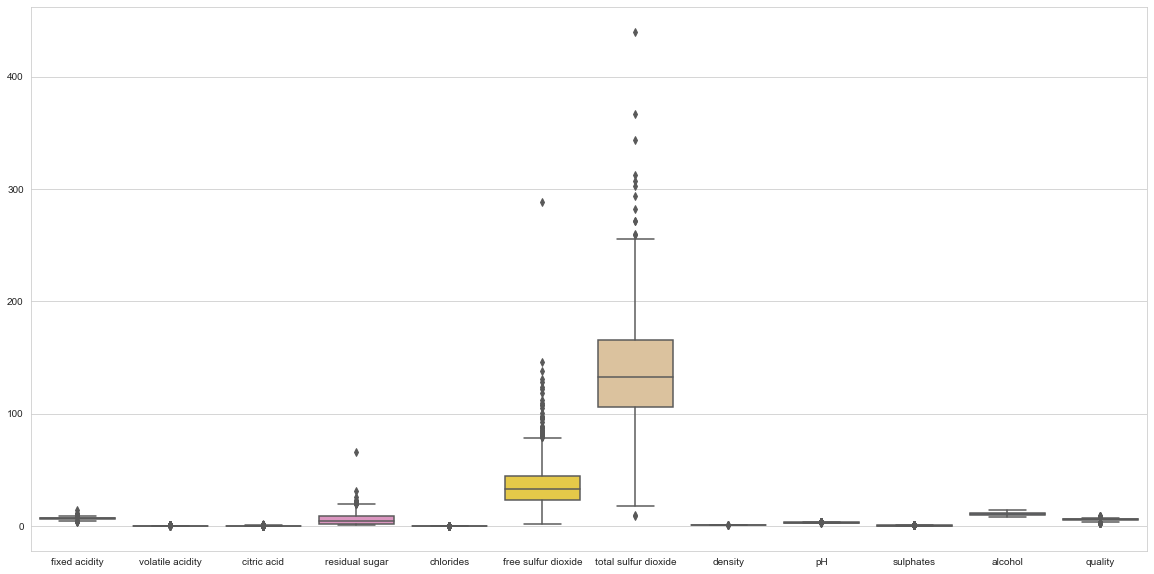

In [6]:
# Check Outliers
plt.figure(figsize=(20, 10))
sns.boxplot(data=df, orient="v", palette="Set2")
plt.show

## Balancing the dataset

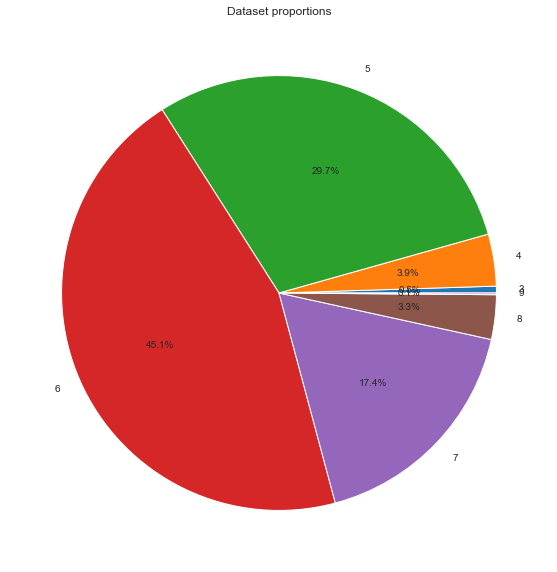

In [7]:
# Notice how unbalanced is the dataset
labels, counts = np.unique(df.quality, return_counts=True)

plt.figure(figsize=(10, 10))
plt.pie(counts, autopct='%1.1f%%', labels=labels)
plt.title('Dataset proportions')
plt.show()

We observe that data is not balanced, we need to balalnce the data

In [8]:
x = df.drop('quality', axis=1)
y = df.quality

In [9]:
over = SMOTE(sampling_strategy='auto',k_neighbors=4)
under = RandomUnderSampler(sampling_strategy='auto')

steps = [('o', over), ('u', under)]
imb_pipeline = IMBPipeline(steps=steps)
# transform the dataset
x_sm, y_sm = imb_pipeline.fit_resample(x, y)

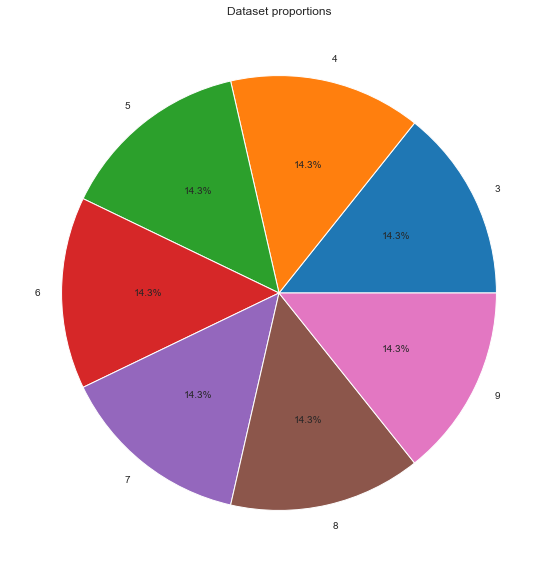

In [10]:
labels, counts = np.unique(y_sm, return_counts=True)

plt.figure(figsize=(10, 10))
plt.pie(counts, autopct='%1.1f%%', labels=labels)
plt.title('Dataset proportions')
plt.show()

## Data Transformation

In [11]:
# Selecting categorical and numeric features
sel_numeric = make_column_selector(dtype_include=np.number)
x_numerical = sel_numeric(x_sm)

sel_categorical = make_column_selector(dtype_exclude=np.number)
x_categorical = sel_categorical(x_sm)

In [12]:
x_numerical

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [13]:
# Create preprocessing pipelines for each datatype
trans_numerical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]
)

In [14]:
trans_categorical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder()),
    ('scaler', StandardScaler())]
)

In [15]:
# Putting the preprocessing steps together
transformer = ColumnTransformer([
    # ('categorical', trans_categorical, x_categorical),
    ('numerical', trans_numerical, x_numerical)],
remainder='passthrough'
)

In [16]:
x_trans = transformer.fit_transform(x_sm)

In [17]:
x_trans

array([[ 1.55531603, -0.41230513, -1.24013743, ..., -1.40330821,
         0.16949422, -0.91051431],
       [-1.30259118, -0.60277697,  0.99357819, ...,  2.23945783,
        -0.50837842,  0.59502762],
       [ 2.19040653,  2.73048021,  0.41086977, ...,  0.09665427,
        -0.99257317, -1.94062194],
       ...,
       [-0.07486892,  0.40317208,  0.04566202, ...,  0.4537882 ,
        -1.04706506,  1.36843648],
       [-0.04266717,  0.11001748,  0.68020061, ...,  0.74406227,
        -0.92388604,  1.45897869],
       [ 0.00283502, -0.09468296,  0.99331952, ...,  0.88223476,
        -0.79899844,  1.49304203]])

## Model Training

In [18]:
# Data Split
x_train, x_test, y_train, y_test = train_test_split(x_sm, y_sm, shuffle=True, test_size=0.2)

x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# le = LabelEncoder()
# y_train_trans = le.fit_transform(y_train)

## mord Algorithm

In [19]:
# Create pipeline with mord model as classifier
pipeline = PMMLPipeline(steps=[
    ('transformer', transformer),
    ('classifier', mord.LogisticIT(alpha=1.0))
])

pipeline.fit(x_train, y_train)
pipeline.verify(x_train.sample(n = 10))

In [20]:
y_pred = pipeline.predict(x_test)
# y_pred = le.inverse_transform(y_pred)
y_pred

array([3, 3, 6, ..., 7, 9, 7])

## Model Testing

In [21]:
print(f'The model accuracy is: {np.round(accuracy_score(y_test, y_pred), decimals=3)*100}%')

The model accuracy is: 32.1%


In [22]:
print(f'The model f1 score is: {np.round(f1_score(y_test, y_pred, average="""weighted"""), decimals=3)*100}%')

The model f1 score is: 29.099999999999998%


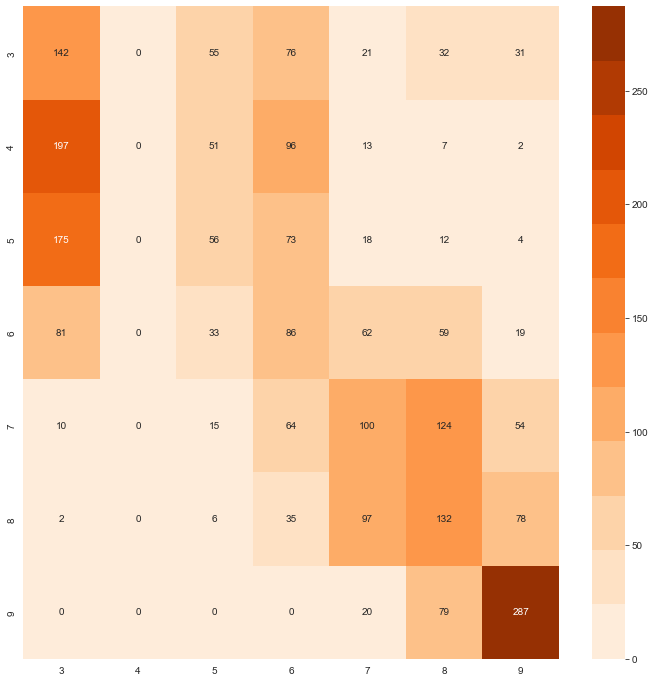

In [23]:
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
plt.figure(figsize=(12, 12))
cmap = sns.color_palette("Oranges",12)
sns.heatmap(data=cm, cmap=cmap, xticklabels=pipeline.classes_, yticklabels=pipeline.classes_, fmt='g', annot=True)
plt.show()

## Multinomial Logistic Regression

In [24]:
# Create pipeline with logistic regression as classifier
pipeline = PMMLPipeline(steps=[
    ('transformer', transformer),
    ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000))
])

pipeline.fit(x_train, y_train)
pipeline.verify(x_train.sample(n = 10))

In [25]:
y_pred = pipeline.predict(x_test)
# y_pred = le.inverse_transform(y_pred)
y_pred

array([4, 3, 8, ..., 8, 9, 8])

In [26]:
print(f'The model accuracy is: {np.round(accuracy_score(y_test, y_pred), decimals=3)*100}%')

The model accuracy is: 55.00000000000001%


In [27]:
print(f'The model f1 score is: {np.round(f1_score(y_test, y_pred, average="""weighted"""), decimals=3)*100}%')

The model f1 score is: 54.1%


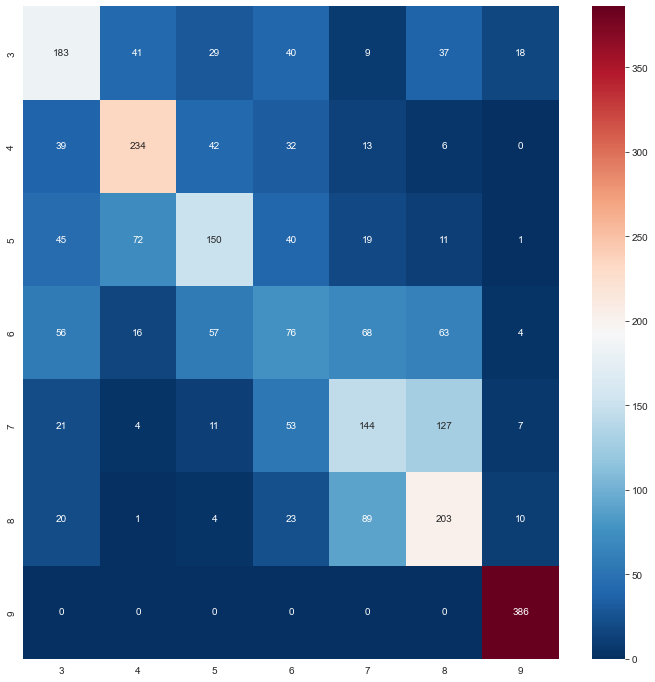

In [28]:
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
plt.figure(figsize=(12, 12))
cmap = sns.color_palette("Oranges",12)
sns.heatmap(data=cm, cmap="RdBu_r", xticklabels=pipeline.classes_, yticklabels=pipeline.classes_, fmt='g', annot=True)
plt.show()

As we can observer, the diagonal value is the highest value for each row which means we have a good classifier.

## Ordered Model

In [42]:
# Create pipeline with logistic regression as classifier
pipeline = PMMLPipeline(steps=[
    ('transformer', transformer),
    ('classifier', OrderedModel(y_train, x_train, distr='probit'))
])

om = OrderedModel(y_train, x_train, distr='probit')
res_prob = om.fit(method='bfgs')
predicted = res_prob.model.predict(res_prob.params, exog=x_test)
predictions = pd.DataFrame(predicted)
pred = predictions.idxmax(axis=1).to_frame().rename(columns={0: 'Parallel_pred'})
df_pred = pd.merge(pred.reset_index(),pred,left_index=True, right_index=True)
cm=confusion_matrix(df_pred['Parallel_pred_x'],df_pred['Parallel_pred_y'])
print (cm)

# pipeline.fit(method='bfgs')
# pipeline.fit(x_train, y_train)
# pipeline.verify(x_train.sample(n = 10))

Optimization terminated successfully.
         Current function value: 1.638896
         Iterations: 107
         Function evaluations: 111
         Gradient evaluations: 111
[[639   0   0   0   0   0]
 [  0 198   0   0   0   0]
 [  0   0 474   0   0   0]
 [  0   0   0 378   0   0]
 [  0   0   0   0 337   0]
 [  0   0   0   0   0 478]]


## Ordinal Classifier

In [83]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone, BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array
from sklearn.utils.multiclass import check_classification_targets
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

In [101]:
# class OrdinalClassifier(BaseEstimator, ClassifierMixin):
class OrdinalClassifier(BaseEstimator):
    """
    Helper class that solves ordinal classification (classes that have an order to them eg cold,warm,hot)
    """
    def __init__(self,classifier=None,clf_args=None):
        """
        y needs to be a number that start from 0 and increments by 1
        classifier object needs to be able to return a probability
        """
        self.classifier = classifier
        self.clfs = []
        self.clf_args = clf_args
        self.final_prob = None

    def fit(self,X,y,**fit):
        self.X = X
        self.y = y
        import copy
        no_of_classifiers = np.max(self.y) #since y starts from 0
        self.classes_ = list(range(no_of_classifiers+1))
        if isinstance(self.clf_args,list):
            #for pipelines
            c = self.classifier(self.clf_args)
        elif isinstance(self.clf_args,dict):
            #for normal estimators
            c = self.classifier(**self.clf_args)
        for i in range(no_of_classifiers):
            # make a copy of y because we want to change the values of y
            copy_y = np.copy(self.y)
            # make a binary classification here
            copy_y[copy_y<=i] = 0
            copy_y[copy_y>i] = 1
            classifier = copy.deepcopy(c)
            classifier.fit(self.X,copy_y,**fit)
            self.clfs.append(classifier)
        return self
    def predict_proba(self,test):
        prob_list = []
        final_prob = []
        length = len(self.clfs)
        for clf in self.clfs:
            prob_list.append(clf.predict_proba(test)[:,1])
        for i in range(length+1):
            if i == 0:
                final_prob.append(1-prob_list[i])
            elif i == length:
                final_prob.append(prob_list[i-1])
            else:
                final_prob.append(prob_list[i-1]-prob_list[i])
        answer = np.array(final_prob).transpose()
        self.final_prob= answer
        return answer
    def predict(self,test):
        self.predict_proba(test)
        return np.argmax(self.final_prob,axis=1)
    def score(self,X,y,sample_weight=None):
        from sklearn.metrics import accuracy_score
        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)

In [103]:
# Create pipeline with mord model as classifier
pipeline = PMMLPipeline(steps=[
    ('transformer', transformer),
    ('classifier', OrdinalClassifier(LogisticRegression(max_iter=1000)))
])

pipeline.fit(x_train, y_train)
pipeline.verify(x_train.sample(n = 10))

UnboundLocalError: local variable 'c' referenced before assignment

In [99]:
y_pred = pipeline.predict(x_test)
y_pred

array([2, 5, 1, ..., 5, 5, 4])

In [100]:
print(f'The model accuracy is: {np.round(accuracy_score(y_test, y_pred), decimals=3)*100}%')

The model accuracy is: 2.8000000000000003%
